# 05 - Model Comparison

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv("../data/processed_fraud.csv")
X = df.drop(columns=["isFraud"])
y = df["isFraud"]

# Standardize for Bayesian
X_std = (X - X.mean()) / X.std()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_std = (X_train - X.mean()) / X.std()
X_test_std = (X_test - X.mean()) / X.std()

In [4]:

# Logistic Regression
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_clf.fit(X_train, y_train)
log_probs = log_clf.predict_proba(X_test)[:, 1]

In [5]:
# Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
nb_probs = nb_clf.predict_proba(X_test)[:, 1]


In [6]:
# Bayesian Logistic Regression
X_bayes = X_std.iloc[:5000].values
y_bayes = y[:5000].values

In [7]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=X_bayes.shape[1])
    logits = intercept + pm.math.dot(X_bayes, coefs)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_bayes)
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, coefs]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 194 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
bayes_probs = trace.posterior["p"].mean(dim=["chain", "draw"]).values.flatten()

# Compare
models = {
    "Logistic Regression": (y_test, log_probs),
    "Naive Bayes": (y_test, nb_probs),
    "Bayesian Logistic Regression": (y_bayes, bayes_probs)
}

for name, (y_true, y_score) in models.items():
    print(f"\n{name}:")
    print("ROC AUC:", roc_auc_score(y_true, y_score))
    print("Classification Report:\n", classification_report(y_true, (y_score > 0.5).astype(int)))



Logistic Regression:
ROC AUC: 0.9873750374620314
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.92      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.94      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524


Naive Bayes:
ROC AUC: 0.8074997681948395
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.03      0.16      0.06      1643

    accuracy                           0.99   1272524
   macro avg       0.52      0.58      0.53   1272524
weighted avg       1.00      0.99      1.00   1272524


Bayesian Logistic Regression:
ROC AUC: 0.9667741935483871
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4960
           1  

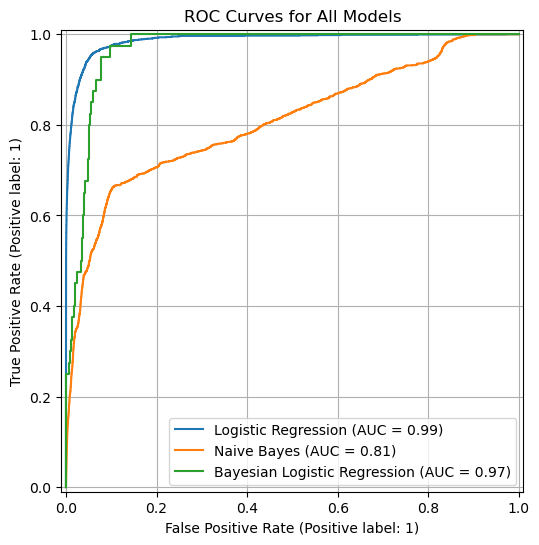

In [9]:
# ROC Curves
plt.figure(figsize=(8, 6))
for name, (y_true, y_score) in models.items():
    RocCurveDisplay.from_predictions(y_true, y_score, name=name, ax=plt.gca())
plt.title("ROC Curves for All Models")
plt.grid()
plt.show()

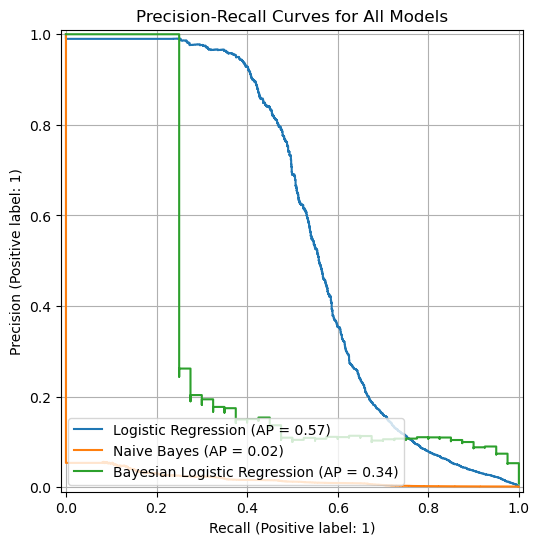

In [10]:
# Precision-Recall Curves
plt.figure(figsize=(8, 6))
for name, (y_true, y_score) in models.items():
    PrecisionRecallDisplay.from_predictions(y_true, y_score, name=name, ax=plt.gca())
plt.title("Precision-Recall Curves for All Models")
plt.grid()
plt.show()